# Convergence of estimators on Ishigami

In this example, we present the convergence of the sensitivity indices of the Ishigami test function.

We compare different estimators.
* Sampling methods with different estimators: Saltelli, Mauntz-Kucherenko (TODO), Martinez (TODO), Jansen (TODO),
* Sampling methods with different design of experiments: Monte-Carlo, LHS, Quasi-Monte-Carlo (TODO),
* Polynomial chaos (TODO).

In [1]:
import openturns as ot
import otbenchmark as otb
import openturns.viewer as otv
import time
import numpy as np

In [2]:
problem = otb.IshigamiSensitivity()

In [3]:
print(problem)

name = Ishigami
distribution = ComposedDistribution(Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), IndependentCopula(dimension = 3))
function = ParametricEvaluation([X1,X2,X3,a,b]->[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)], parameters positions=[3,4], parameters=[a : 7, b : 0.1], input positions=[0,1,2])
firstOrderIndices = [0.313905,0.442411,0]
totalOrderIndices = [0.557589,0.442411,0.243684]


In [4]:
distribution = problem.getInputDistribution()
model = problem.getFunction()

In [5]:
# Exact first and total order
exact_first_order = problem.getFirstOrderIndices()
exact_first_order

class=Point name=Unnamed dimension=3 values=[0.313905,0.442411,0]

In [6]:
exact_total_order = problem.getTotalOrderIndices()
exact_total_order

class=Point name=Unnamed dimension=3 values=[0.557589,0.442411,0.243684]

## Perform sensitivity analysis

In [7]:
# Create X/Y data
ot.RandomGenerator.SetSeed(0)
size = 10000
inputDesign = ot.SobolIndicesExperiment(distribution, size).generate()
outputDesign = model(inputDesign)

In [8]:
# Compute first order indices using the Saltelli estimator
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
computed_first_order = sensitivityAnalysis.getFirstOrderIndices()
computed_total_order = sensitivityAnalysis.getTotalOrderIndices()

In [9]:
# Compare with exact results
print("Sample size : ", size)
# First order
# Compute absolute error (the LRE cannot be computed,
# because S can be zero)
print("Computed first order = ", computed_first_order)
print("Exact first order    = ", exact_first_order)
# Total order
print("Computed total order = ", computed_total_order)
print("Exact total order    = ", exact_total_order)

Sample size :  10000
Computed first order =  [0.302745,0.460846,0.0066916]
Exact first order    =  [0.313905,0.442411,0]
Computed total order =  [0.574996,0.427126,0.256689]
Exact total order    =  [0.557589,0.442411,0.243684]


In [10]:
dimension = distribution.getDimension()

In [11]:
first_order_LRE = ot.Point(dimension)
total_order_LRE = ot.Point(dimension)
for i in range(dimension):
    first_order_LRE[i] = otb.ComputeLogRelativeError(
        exact_first_order[i], computed_first_order[i]
    )
    total_order_LRE[i] = otb.ComputeLogRelativeError(
        exact_total_order[i], computed_total_order[i]
    )

In [12]:
for i in range(dimension):
    print(
        "LRE(S%d) = %.2f, LRE(T%d) = %.2f"
        % (i, first_order_LRE[i], i, total_order_LRE[i])
    )

LRE(S0) = 1.45, LRE(T0) = 1.51
LRE(S1) = 1.38, LRE(T1) = 1.46
LRE(S2) = 0.00, LRE(T2) = 1.27


In [13]:
def compute_LRE_by_MonteCarlo_sampling(problem, sample_size):
    """
    Compute the LRE for the given problem with Monte-Carlo sample.
    
    Uses Saltelli.
    """
    distribution = problem.getInputDistribution()
    model = problem.getFunction()
    # Create X/Y data
    inputDesign = ot.SobolIndicesExperiment(distribution, sample_size).generate()
    outputDesign = model(inputDesign)
    # Compute first order indices using the Saltelli estimator
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
        inputDesign, outputDesign, sample_size
    )
    computed_first_order = sensitivityAnalysis.getFirstOrderIndices()
    computed_total_order = sensitivityAnalysis.getTotalOrderIndices()
    dimension = distribution.getDimension()
    first_order_LRE = ot.Point(dimension)
    total_order_LRE = ot.Point(dimension)
    for i in range(dimension):
        first_order_LRE[i] = otb.ComputeLogRelativeError(
            exact_first_order[i], computed_first_order[i]
        )
        total_order_LRE[i] = otb.ComputeLogRelativeError(
            exact_total_order[i], computed_total_order[i]
        )
    return first_order_LRE, total_order_LRE

In [14]:
startTime = time.time()

In [15]:
numberOfPoints = 12  # Number of atomic experiments
numberOfRepetitions = 10  # Number of repetitions of each experiment
sampleSizeLRETable = ot.Sample(numberOfPoints * numberOfRepetitions, 2)
sampleSizeLRETable.setDescription(["Sample size", "LRE"])

In [16]:
sample_size_initial = 20
sample_size = sample_size_initial
marginal_index = 0
first_order = True
index = 0
for i in range(numberOfPoints):
    sample_size *= 2
    print("Sample size = ", sample_size)
    for j in range(numberOfRepetitions):
        first_order_LRE, total_order_LRE = compute_LRE_by_MonteCarlo_sampling(
            problem, sample_size
        )
        sampleSizeLRETable[index, 0] = sample_size
        if first_order:
            sampleSizeLRETable[index, 1] = first_order_LRE[marginal_index]
        else:
            sampleSizeLRETable[index, 1] = total_order_LRE[marginal_index]
        index += 1
sample_size_final = sample_size

Sample size =  40
Sample size =  80
Sample size =  160
Sample size =  320
Sample size =  640
Sample size =  1280
Sample size =  2560
Sample size =  5120
Sample size =  10240
Sample size =  20480
Sample size =  40960
Sample size =  81920


In [17]:
elapsedTime = time.time() - startTime
print("Elapsed = %.2f (s)" % (elapsedTime))

Elapsed = 2.47 (s)


In [18]:
sampleSizeArray = [
    int(n)
    for n in np.logspace(np.log10(sample_size_initial), np.log10(sample_size_final))
]
expectedConvergence = [-np.log10(1.0 / np.sqrt(n)) for n in sampleSizeArray]

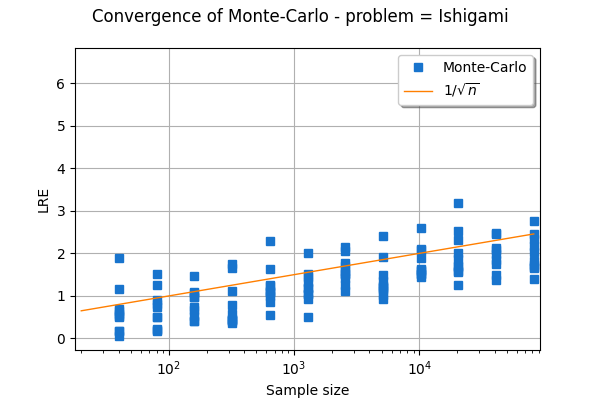

In [20]:
title = "Convergence of Monte-Carlo - problem = %s" % (problem.getName())
graph = ot.Graph(title, "Sample size", "LRE", True, "topright")
curve = ot.Cloud(sampleSizeLRETable, "blue", "fsquare", "")
curve.setLegend("Monte-Carlo")
graph.add(curve)
curve = ot.Curve(sampleSizeArray, expectedConvergence)
curve.setLegend(r"$1/\sqrt{n}$")
graph.add(curve)
graph.setColors(["dodgerblue3", "darkorange1"])
graph.setLogScale(ot.GraphImplementation.LOGX)
graph